In [1]:
import warnings 
warnings.filterwarnings('ignore')

### xtreme PAN-X datasets

Data have sequnce with marked word with NER tags
NER (Name entity recognision) is tags of PER (persone), ORG (organization) and LOC (locations)

In [2]:
# hide_output
from collections import defaultdict
from datasets import DatasetDict, load_dataset

langs = ["de", "fr", "it", "en"]
fracs = [0.629, 0.229, 0.084, 0.059]
# Return a DatasetDict if a key doesn't exist
panx_ch = defaultdict(DatasetDict)

for lang, frac in zip(langs, fracs):
    # Load monolingual corpus
    ds = load_dataset("xtreme", name=f"PAN-X.{lang}")
    # Shuffle and downsample each split according to spoken proportion
    for split in ds:
        panx_ch[lang][split] = (
            ds[split]
            .shuffle(seed=0)
            .select(range(int(frac * ds[split].num_rows))))

Number of train sample in each language

In [3]:
import pandas as pd
pd.DataFrame({lang: [panx_ch[lang]['train'].num_rows] for lang in langs}, index=['Number of train samples'])

,de,fr,it,en
Number of train samples,12580,4580,1680,1180


### Convert ner_tags_id to ner_tags_str for german corpus

In [4]:
tags = panx_ch['de']['train'].features['ner_tags'].feature

def tags2str(batch):
    return {"ner_tags_str": [tags.int2str(idx) for idx in batch["ner_tags"]]}

panx_de = panx_ch['de'].map(tags2str)

### take  number of each tags in german corpus

In [5]:
from collections import Counter

split2freqs = defaultdict(Counter)
for split, dataset in panx_de.items():
    for row in dataset["ner_tags_str"]:
        for tag in row:
            if tag.startswith("B"):
                tag_type = tag.split("-")[1]
                split2freqs[split][tag_type] += 1
                
pd.DataFrame.from_dict(split2freqs, orient="index")

,LOC,ORG,PER
train,6186,5366,5810
validation,3172,2683,2893
test,3180,2573,3071


# Tokenizer

From Hugging Face API import toeknizer mdoel for BERT model and XLMR model

In [6]:
from transformers import AutoTokenizer

bert_model_name = 'bert-base-cased'
xlmr_model_name = 'xlm-roberta-base'

bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
xlmr_tokenizer = AutoTokenizer.from_pretrained(xlmr_model_name)

text = "Jack Sparrow loves New York!"
bert_tokens = bert_tokenizer.tokenize(text)
xlmr_tokens = xlmr_tokenizer.tokenize(text)

pd.DataFrame([bert_tokens, xlmr_tokens], index=['BERT Tokenizer', 'XLM-R Tokenizer'])

,0,1,2,3,4,5,6,7
BERT Tokenizer,Jack,Spa,##rrow,loves,New,York,!,None
XLM-R Tokenizer,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!


### Model

Create model using RobertaModel for hugging face tranformers. Normaly we have XLMRobertaForTokenClassification bulid class but we can make for own hand for sport :)

In [7]:
import torch.nn as nn
from transformers import XLMRobertaConfig
from transformers.modeling_outputs import TokenClassifierOutput
from transformers.models.roberta.modeling_roberta import RobertaModel
from transformers.models.roberta.modeling_roberta import RobertaPreTrainedModel

class XLMRobertaForTokenClassification(RobertaPreTrainedModel):
    config_class = XLMRobertaConfig

    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        # Load model body
        self.roberta = RobertaModel(config, add_pooling_layer=False)
        # Set up token classification head
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        # Load and initialize weights
        self.init_weights()

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, 
                labels=None, **kwargs):
        # Use model body to get encoder representations
        outputs = self.roberta(input_ids, attention_mask=attention_mask,
                               token_type_ids=token_type_ids, **kwargs)
        # Apply classifier to encoder representation
        sequence_output = self.dropout(outputs[0])
        logits = self.classifier(sequence_output)
        # Calculate losses
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        # Return model output object
        return TokenClassifierOutput(loss=loss, logits=logits, 
                                     hidden_states=outputs.hidden_states, 
                                     attentions=outputs.attentions)

### Config for XLMR model

In [8]:
from transformers import AutoConfig 

index2tag = {idx: tag for idx, tag in enumerate(tags.names)}
tag2index = {tag: idx for idx, tag in enumerate(tags.names)}

xlmr_config = AutoConfig.from_pretrained(xlmr_model_name, 
                                         num_labels=tags.num_classes,
                                         id2label=index2tag, label2id=tag2index)

Device agnostict code


In [9]:
import torch 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = (XLMRobertaForTokenClassification
         .from_pretrained(xlmr_model_name)
         .to(device))

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
def tag_text(text, tags, model, tokenizer):
    # Get tokens with special characters
    tokens = tokenizer(text).tokens()
    # Encode the sequence into IDs
    input_ids = xlmr_tokenizer(text, return_tensors="pt").input_ids.to(device)
    # Get predictions as distribution over 7 possible classes
    outputs = model(input_ids)[0]
    # Take argmax to get most likely class per token
    predictions = torch.argmax(outputs, dim=2)
    # Convert to DataFrame
    preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
    return pd.DataFrame([tokens, preds], index=["Tokens", "Tags"])

Prepering sequnce for training

In [11]:
import pandas as pd

de_example = panx_de['train'][0]
words, labels = de_example['tokens'], de_example['ner_tags']

# Tokenize the input while keeping track of the word boundaries
tokenized_input = xlmr_tokenizer(words, is_split_into_words=True)
word_ids = tokenized_input.word_ids()
tokens = xlmr_tokenizer.convert_ids_to_tokens(tokenized_input['input_ids'])

previous_word_idx = None
labels_id = []

# Align the labels with the tokens
for word_idx in word_ids:
    if word_idx is None or word_idx == previous_word_idx:
        labels_id.append(-100)
    else:
        labels_id.append(labels[word_idx])
    previous_word_idx = word_idx

# Convert label ids to tag names
labels = [tags.names[l] if l != -100 else 'IGN' for l in labels_id]

# Create a DataFrame to display tokens, word_ids, and labels
pd.DataFrame([tokens, word_ids, labels_id, labels], index=['Tokens', 'Word IDs', 'Label ID', 'Labels'])



,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
Word IDs,None,0,1,1,2,3,4,4,4,5,...,9,9,9,9,10,10,10,11,11,None
Label ID,-100,0,0,-100,0,0,5,-100,-100,6,...,5,-100,-100,-100,6,-100,-100,0,-100,-100
Labels,IGN,O,O,IGN,O,O,B-LOC,IGN,IGN,I-LOC,...,B-LOC,IGN,IGN,IGN,I-LOC,IGN,IGN,O,IGN,IGN


In [12]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = xlmr_tokenizer(examples["tokens"], truncation=True, 
                                      is_split_into_words=True)
    labels = []
    for idx, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=idx)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None or word_idx == previous_word_idx:
                label_ids.append(-100)
            else:
                label_ids.append(label[word_idx])
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [13]:
def encode_panx_dataset(corpus):
    return corpus.map(tokenize_and_align_labels, batched=True, 
                      remove_columns=['langs', 'ner_tags', 'tokens'])

In [14]:
panx_de_encoded = encode_panx_dataset(panx_ch["de"])

Function for callcualte F1 score using seqeval library. This use 2d np.array to callcualte F1 score 
We need somthing like 

y_true = [["O", "O", "O", "B-MISC", "I-MISC", "I-MISC", "O"],
          ["B-PER", "I-PER", "O"]]
y_pred = [["O", "O", "B-MISC", "I-MISC", "I-MISC", "I-MISC", "O"],
          ["B-PER", "I-PER", "O"]]

In [15]:
import numpy as np

def align_predictions(predictions, label_ids):
    preds = np.argmax(predictions, axis=2)
    batch_size, seq_len = preds.shape
    labels_list, preds_list = [], []

    for batch_idx in range(batch_size):
        example_labels, example_preds = [], []
        for seq_idx in range(seq_len):
            # Ignore label IDs = -100
            if label_ids[batch_idx, seq_idx] != -100:
                example_labels.append(index2tag[label_ids[batch_idx][seq_idx]])
                example_preds.append(index2tag[preds[batch_idx][seq_idx]])

        labels_list.append(example_labels)
        preds_list.append(example_preds)

    return preds_list, labels_list

In [16]:
from seqeval.metrics import f1_score

def compute_metrics(eval_pred):
    y_pred, y_true = align_predictions(eval_pred.predictions, 
                                       eval_pred.label_ids)
    return {"f1": f1_score(y_true, y_pred)}

### Train Model

In [17]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(xlmr_tokenizer)

In [18]:
def model_init():
    return (XLMRobertaForTokenClassification
            .from_pretrained(xlmr_model_name, config=xlmr_config)
            .to(device))

In [19]:
from transformers import TrainingArguments

num_epochs = 3
batch_size = 32
logging_steps = len(panx_de_encoded["train"]) // batch_size
model_name = f"{xlmr_model_name}-finetuned-panx-de"
training_args = TrainingArguments(
    output_dir=model_name, log_level="error", num_train_epochs=num_epochs, 
    per_device_train_batch_size=batch_size, 
    per_device_eval_batch_size=batch_size, evaluation_strategy="epoch", 
    save_steps=1e6, weight_decay=0.01, disable_tqdm=False, 
    logging_steps=logging_steps, push_to_hub=False)

In [20]:
from transformers import Trainer

trainer = Trainer(model_init=model_init, args=training_args, 
                  data_collator=data_collator, compute_metrics=compute_metrics,
                  train_dataset=panx_de_encoded["train"],
                  eval_dataset=panx_de_encoded["validation"], 
                  tokenizer=xlmr_tokenizer)

In [21]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,0.264600,0.155004,0.821922
2,0.129800,0.132727,0.850252
3,0.081900,0.132643,0.859513


TrainOutput(global_step=1182, training_loss=0.15861214717531769, metrics={'train_runtime': 4887.5, 'train_samples_per_second': 7.722, 'train_steps_per_second': 0.242, 'total_flos': 915051570323352.0, 'train_loss': 0.15861214717531769, 'epoch': 3.0})

### Testing model

In [22]:
df = pd.DataFrame(trainer.state.log_history)[['epoch','loss' ,'eval_loss', 'eval_f1']]
df = df.rename(columns={"epoch":"Epoch","loss": "Training Loss", "eval_loss": "Validation Loss", "eval_f1":"F1"})
df['Epoch'] = df["Epoch"].apply(lambda x: round(x))
df['Training Loss'] = df["Training Loss"].ffill()
df[['Validation Loss', 'F1']] = df[['Validation Loss', 'F1']].bfill().ffill() # .bfill .ffill   
df.drop_duplicates()

,Epoch,Training Loss,Validation Loss,F1
0,1,0.2646,0.155004,0.821922
2,2,0.1298,0.132727,0.850252
4,3,0.0819,0.132643,0.859513


In [23]:
text_de = "Jeff Dean ist ein Informatiker bei Google in Kalifornien"
tag_text(text_de, tags, trainer.model, xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Tokens,<s>,▁Jeff,▁De,an,▁ist,▁ein,▁Informati,ker,▁bei,▁Google,▁in,▁Kaliforni,en,</s>
Tags,O,B-PER,I-PER,I-PER,O,O,O,O,O,B-ORG,O,B-LOC,I-LOC,O


### Error analisys

In [24]:
import torch.nn.functional as F

def forward_pass_with_label(batch):
    # Convert dict of lists to list of dicts suitable for data collator
    features = [dict(zip(batch, t)) for t in zip(*batch.values())]
    # Pad inputs and labels and put all tensors on device
    batch = data_collator(features)
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)
    with torch.no_grad():
        # Pass data through model  
        output = trainer.model(input_ids, attention_mask)
        # Logit.size: [batch_size, sequence_length, classes]
        # Predict class with largest logit value on classes axis
        predicted_label = torch.argmax(output.logits, axis=-1).cpu().numpy()
    # Calculate loss per token after flattening batch dimension with view
    loss = F.cross_entropy(output.logits.view(-1, 7), 
                         labels.view(-1), reduction="none")
    # Unflatten batch dimension and convert to numpy array
    loss = loss.view(len(input_ids), -1).cpu().numpy()

    return {"loss":loss, "predicted_label": predicted_label}

In [25]:
validation_set = panx_de_encoded['validation']
validation_set = validation_set.map(forward_pass_with_label, batched=True, batch_size=32)
df = validation_set.to_pandas()

Map: 100%|█████████████████████████████████████████████████████████████████| 6290/6290 [00:20<00:00, 314.43 examples/s]


In [26]:
index2tag[-100] = "IGN"
df["input_tokens"] = df["input_ids"].apply(lambda x: xlmr_tokenizer.convert_ids_to_tokens(x))
df["predicted_label"] = df["predicted_label"].apply(lambda x: [index2tag[i] for i in x])
df["labels"] = df["labels"].apply(lambda x: [index2tag[i] for i in x])
df['loss'] = df.apply(lambda x: x['loss'][:len(x['input_ids'])], axis=1)
df['predicted_label'] = df.apply(lambda x: x['predicted_label'][:len(x['input_ids'])], axis=1)
df.head(1)

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,"[0, 10699, 11, 15, 16104, 1388, 2]","[1, 1, 1, 1, 1, 1, 1]","[IGN, B-ORG, IGN, I-ORG, I-ORG, I-ORG, IGN]","[0.0, 0.016963387, 0.0, 0.019738328, 0.0173121...","[I-ORG, B-ORG, I-ORG, I-ORG, I-ORG, I-ORG, I-ORG]","[<s>, ▁Ham, a, ▁(, ▁Unternehmen, ▁), </s>]"


In [27]:
df_tokens = df.apply(pd.Series.explode)
df_tokens = df_tokens.query("labels != 'IGN'")
df_tokens['loss'] = df_tokens['loss'].astype(float).round(2)
df_tokens.head(5)

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,10699,1,B-ORG,0.02,B-ORG,▁Ham
0,15,1,I-ORG,0.02,I-ORG,▁(
0,16104,1,I-ORG,0.02,I-ORG,▁Unternehmen
0,1388,1,I-ORG,0.02,I-ORG,▁)
1,56530,1,O,0.00,O,▁WE


Value of count, mean and sum on group input_tokens

In [28]:
(
    df_tokens.groupby("input_tokens")[["loss"]]
    .agg(["count", "mean", "sum"])
    .droplevel(level=0, axis=1)  # Get rid of multi-level columns
    .sort_values(by="sum", ascending=False)
    .reset_index()
    .round(2)
    .head(10)
    .T
)

,0,1,2,3,4,5,6,7,8,9
input_tokens,▁,▁der,▁in,▁von,▁/,▁und,▁(,▁),▁'',▁A
count,6066,1388,989,808,163,1171,246,246,2898,125
mean,0.03,0.1,0.12,0.13,0.6,0.07,0.3,0.29,0.02,0.41
sum,191.43,134.83,115.9,107.88,97.45,86.71,72.95,71.23,58.81,51.49


Value of count, mean and sum on tags group

In [29]:
(
    df_tokens.groupby('labels')[['loss']]
    .agg(['count', 'mean', 'sum'])
    .droplevel(level=0, axis=1)
    .sort_values(by='sum', ascending=False)
    .reset_index()
    .round(2)
    .head(10)
    .T
)

,0,1,2,3,4,5,6
labels,I-ORG,B-ORG,O,B-LOC,I-LOC,B-PER,I-PER
count,3820,2683,43648,3172,1462,2893,4139
mean,0.5,0.58,0.03,0.34,0.64,0.26,0.17
sum,1892.03,1565.76,1201.32,1089.95,931.13,761.5,720.72


In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', values_format='.2f', ax=ax, colorbar=False)
    plt.title('Normalizate confusion matrix')

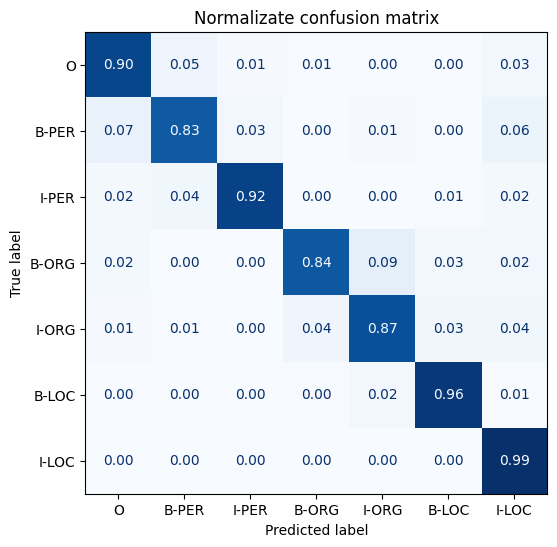

In [31]:
plot_confusion_matrix(df_tokens["labels"], df_tokens["predicted_label"],
                      tags.names)

In [32]:
def get_samples(df):
    for _, row in df.iterrows():
        labels, pred, tokens, losses = [], [], [], []
        for i, _ in enumerate(row['attention_mask']):
            if i not in {0, len(row['attention_mask']) - 1}:
                labels.append(row['labels'][i])
                pred.append(row['predicted_label'][i])
                tokens.append(row['input_tokens'][i])
                losses.append(row['loss'][i])
        df_tmp = pd.DataFrame({'labels': labels, 'pred': pred,
                               'tokens': tokens, 'loss': losses}).T
        
        yield df_tmp

df['total_loss'] = df['loss'].apply(sum)
df_tmp = df.sort_values(by='total_loss', ascending=False).head(3)

for samples in get_samples(df_tmp):
    display(samples)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
labels,B-ORG,IGN,IGN,I-ORG,I-ORG,I-ORG,I-ORG,IGN,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,IGN,IGN,I-ORG,IGN
pred,O,O,O,O,O,O,O,O,O,O,O,O,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG
tokens,▁'',8,.,▁Juli,▁'',▁:,▁Protest,camp,▁auf,▁dem,▁Gelände,▁der,▁Republika,n,ischen,▁Gar,de
loss,7.84211,0.0,0.0,8.011445,9.230934,8.816395,6.432691,0.0,7.53128,8.25764,7.800438,6.701521,6.33264,0.0,0.0,0.013968,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
labels,O,O,O,IGN,O,O,B-LOC,I-LOC,I-LOC,I-LOC,I-LOC,IGN,I-LOC,I-LOC,IGN,I-LOC,I-LOC,IGN
pred,O,O,B-ORG,I-ORG,O,O,O,O,B-ORG,O,O,O,O,O,O,O,O,O
tokens,▁',▁'',▁Τ,Κ,▁'',▁',▁',▁'',▁T,▁'',▁',ri,▁'',▁',k,▁'',▁',ala
loss,0.000251,0.000307,3.914039,0.0,0.001475,0.000494,11.063596,9.681862,7.124115,5.587479,6.396263,0.0,5.616714,6.191971,0.0,6.41087,7.154621,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
labels,B-PER,I-PER,I-PER,IGN,I-PER,IGN,I-PER,IGN,I-PER,I-PER,I-PER,I-PER,I-PER,I-PER
pred,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG
tokens,▁United,▁Nations,▁Multi,dimensional,▁Integra,ted,▁Stabil,ization,▁Mission,▁in,▁the,▁Central,▁African,▁Republic
loss,6.071374,5.801699,5.709655,0.0,5.762371,0.0,5.703273,0.0,5.307401,4.759665,5.126713,5.261124,5.460624,5.260701


# Test on other language data (Cross-Lingual-Transfer) Model do not see any different language other than Germann

In [33]:
def get_f1_score(trainer, dataset):
    return trainer.predict(dataset).metrics["test_f1"]

In [34]:
f1_scores = defaultdict(dict)
f1_scores["de"]["de"] = get_f1_score(trainer, panx_de_encoded["test"])
print(f"F1-score of [de] model on [de] dataset: {f1_scores['de']['de']:.3f}")

F1-score of [de] model on [de] dataset: 0.864


In [35]:
from collections import defaultdict

def evaluate_lang_performance(lang, trainer):
    # Encode the dataset
    panx_ds = encode_panx_dataset(panx_ch[lang])
    # Return the F1 score for the 'test' split
    return get_f1_score(trainer, panx_ds['test'])

f1_scores['de']['it'] = evaluate_lang_performance('it', trainer)
f1_scores['de']['fr'] = evaluate_lang_performance('fr', trainer)
f1_scores['de']['en'] = evaluate_lang_performance('en', trainer)


Map: 100%|██████████████████████████████████████████████████████████████████| 840/840 [00:00<00:00, 7142.73 examples/s]


In [36]:
for lang, value in f1_scores['de'].items():
    print(f"{lang}: f1 score: {value:.3f}")

de: f1 score: 0.864
it: f1 score: 0.671
fr: f1 score: 0.701
en: f1 score: 0.605


### Fine tune model with different corpus

In [37]:
def train_on_subset(dataset, num_samples):
    train_ds = dataset['train'].shuffle(seed=42).select(range(num_samples))
    valid_ds = dataset['validation']
    test_ds = dataset['test']

    training_args.logging_steps = len(train_ds) // batch_size
    
    trainer = Trainer(model_init=model_init,
                      args=training_args,
                      data_collator=data_collator,
                      compute_metrics=compute_metrics,
                      eval_dataset=valid_ds,
                      train_dataset=train_ds,
                      tokenizer=xlmr_tokenizer)
    
    trainer.train()

    f1_score = get_f1_score(trainer, test_ds)
    
    return pd.DataFrame.from_dict({'num_samples': [len(train_ds)], 'f1_score': [f1_score]})

In [38]:
panx_fr_encoded = encode_panx_dataset(panx_ch['fr'])
metrics_df = train_on_subset(panx_fr_encoded, 200)

for num_sample in [500, 1000, 2000, 4000]:
    metrics_df = pd.concat([metrics_df, train_on_subset(panx_fr_encoded, num_sample)], ignore_index=True)

Epoch,Training Loss,Validation Loss,F1
1,1.735400,1.405035,0.000000
2,1.354700,1.221131,0.034805
3,1.213600,1.143589,0.087630


Epoch,Training Loss,Validation Loss,F1
1,1.515100,1.061487,0.199256
2,0.871400,0.689779,0.563491
3,0.613900,0.586730,0.626155


Epoch,Training Loss,Validation Loss,F1
1,1.150600,0.629849,0.612822
2,0.510500,0.416638,0.725940
3,0.331300,0.379497,0.771348


Epoch,Training Loss,Validation Loss,F1
1,0.834600,0.402459,0.707433
2,0.330600,0.336817,0.791639
3,0.234900,0.329850,0.807679


Epoch,Training Loss,Validation Loss,F1
1,0.609600,0.334118,0.777268
2,0.278700,0.286120,0.821631
3,0.192300,0.272915,0.834593


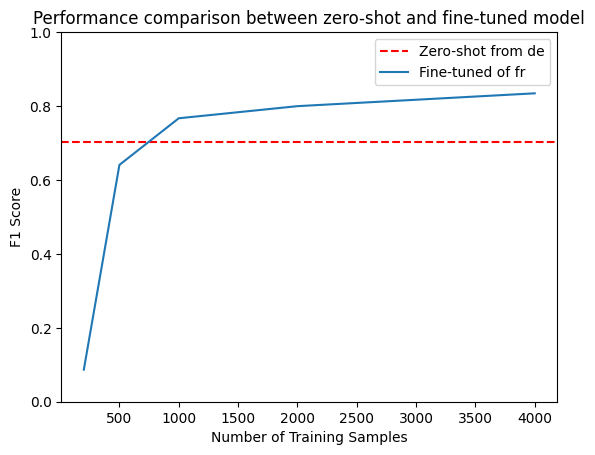

In [42]:
zero_shot_f1 = f1_scores['de']['fr']

fig, ax = plt.subplots()

ax.axhline(zero_shot_f1, ls='--', color='r', label='Zero-shot from de')

metrics_df.set_index('num_samples')['f1_score'].plot(ax=ax)

plt.legend(['Zero-shot from de', 'Fine-tuned of fr'])
plt.ylim(0, 1)
plt.xlabel('Number of Training Samples')
plt.ylabel('F1 Score')
plt.title('Performance comparison between zero-shot and fine-tuned model')

plt.show()


# Fine tune model have better performance after +- 750 samples. In this reason we Fine tune model on Multiple Languges at once

In [46]:
from datasets import concatenate_datasets, DatasetDict

def concatenate_split(corpa):
    multi_corpus = DatasetDict()
    for split in corpa[0].keys():
        # Najpierw połącz zestawy danych
        concatenated_dataset = concatenate_datasets(
            [corpus[split] for corpus in corpa]
        )
        # Następnie przetasuj połączony zbiór danych
        multi_corpus[split] = concatenated_dataset.shuffle(seed=42)
    return multi_corpus

# Wywołanie funkcji
panx_de_fr_encoded = concatenate_split([panx_de_encoded, panx_fr_encoded])


In [48]:
# Upade train args
training_args.logging_steps = len(panx_fr_encoded['train'])//batch_size
training_args.output_dir = 'xlm-roerta-base-finetuned-panx-de-fr'

trainer = Trainer(model_init=model_init,
                  data_collator=data_collator,
                  compute_metrics=compute_metrics,
                  tokenizer=xlmr_tokenizer,
                  train_dataset=panx_de_fr_encoded['train'],
                  eval_dataset=panx_de_fr_encoded['test'])

trainer.train()

{'loss': 0.4296, 'grad_norm': 16.384166717529297, 'learning_rate': 4.611499611499612e-05, 'epoch': 0.2331002331002331}
{'loss': 0.2681, 'grad_norm': 55.00613784790039, 'learning_rate': 4.222999222999223e-05, 'epoch': 0.4662004662004662}
{'loss': 0.2516, 'grad_norm': 19.76923370361328, 'learning_rate': 3.834498834498835e-05, 'epoch': 0.6993006993006993}
{'loss': 0.2269, 'grad_norm': 12.870439529418945, 'learning_rate': 3.445998445998446e-05, 'epoch': 0.9324009324009324}
{'loss': 0.179, 'grad_norm': 1.8741400241851807, 'learning_rate': 3.057498057498058e-05, 'epoch': 1.1655011655011656}
{'loss': 0.1724, 'grad_norm': 13.14477825164795, 'learning_rate': 2.6689976689976692e-05, 'epoch': 1.3986013986013985}
{'loss': 0.1587, 'grad_norm': 10.818258285522461, 'learning_rate': 2.2804972804972807e-05, 'epoch': 1.6317016317016317}
{'loss': 0.1514, 'grad_norm': 5.5030517578125, 'learning_rate': 1.891996891996892e-05, 'epoch': 1.8648018648018647}
{'loss': 0.1256, 'grad_norm': 0.36058124899864197, 'l

KeyboardInterrupt: 